In [117]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random

In [118]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [146]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005

In [120]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty

In [121]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

0.01025850833088569

In [122]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [123]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [124]:
def averageFlux(observations, Frequency):
    b = [0]*len(observations)
    for seconds in range(0, 15):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/15 for z in b]
    return c

In [125]:
def flaring(B, length, frequency=0, amplitude=1):   
    global flareMag
    np.linspace(0,np.log(8),length)
    fouriers = np.linspace(1,3000,length)
    logF = [np.log(x) for x in fouriers]
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    #imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,length, length)
    minutes = [x for x in seconds]
    plt.show()
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT]
    normalised = [x/(np.mean(positive)) for x in positive]
    flareMag = [amplitude * x for x in normalised]
    return flareMag

In [147]:
def lombScargle(frequencyRange, objectmag, modulationAmplitude=0.1, background=40,Nquist=200): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency
    actualperiod = []
    measuredperiod = []
    measuredpower = [] # reset
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange])  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(3,4):#(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)

            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            #maxpos = [i for i, j in enumerate(power) if j == power.max()]
            #LSperiod = (periods[maxpos])
            period = 100./(frequencyRange[frange])
            phase = [(day.value % (period*2))/(period*2) for day in date]

            plt.plot(phase, mag, 'o')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
        actualperiod.append(1/(frequencyRange[frange]*0.01))
        measuredperiod.append(period)
        measuredpower.append(power.max())

In [151]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1)
flaring(-1, 10024, amplitude=0.1)

[(0.15609249770160086+0.01216078304633109j),
 (0.13289318362276506-0.056909788869378378j),
 (0.10530433447321395-0.002387972273319534j),
 (0.094013897984608574-0.03114979205379095j),
 (0.078969246681233063-0.0019951560880413352j),
 (0.11911430695403438-0.0019043393172962547j),
 (0.077847578530024483-0.018105330354921872j),
 (0.080726847707142113+0.0058849976283060802j),
 (0.098503242981907158+0.027823332832671046j),
 (0.10311415704383448-0.023337862455340266j),
 (0.066016471719065009+0.073264615173332326j),
 (0.18313623620632244+0.03049755159576787j),
 (0.14018864981801929-0.067880612714406804j),
 (0.10330712313956698+0.0024967258449334929j),
 (0.093323410599439549-0.01831495675295073j),
 (0.12770450393824137+0.006069424539437842j),
 (0.12758595476838999-0.066283218250814735j),
 (0.038859333491691073-0.016017510823844013j),
 (0.10941400353593976+0.0039184088903235865j),
 (0.096586876886866138-0.0019872919030371134j),
 (0.092338543908477663-0.03155326837559868j),
 (0.080666843513093986-

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


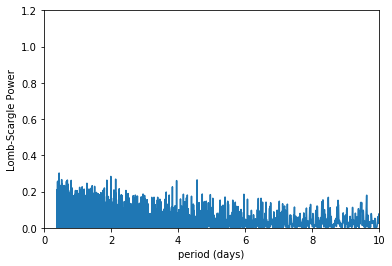

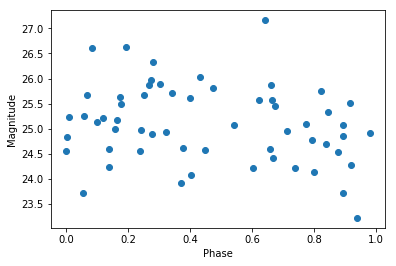

('actualperiod', 0.6666666666666666, 'measured period', 0.01047509960678592) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


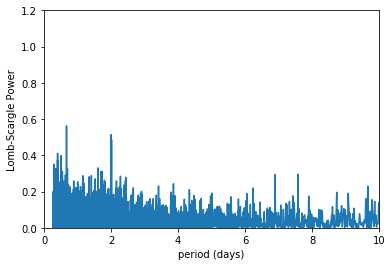

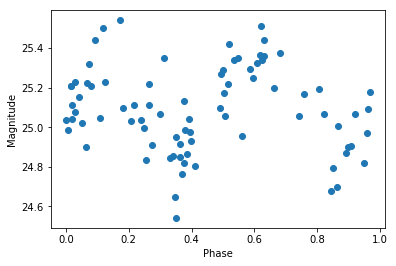

('actualperiod', 0.6666666666666666, 'measured period', 2.0000012664990785) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


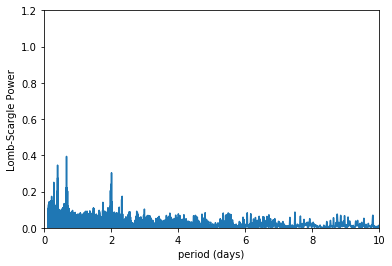

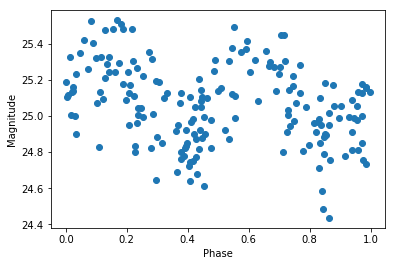

('actualperiod', 0.6666666666666666, 'measured period', 0.66666258084664221) 150
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


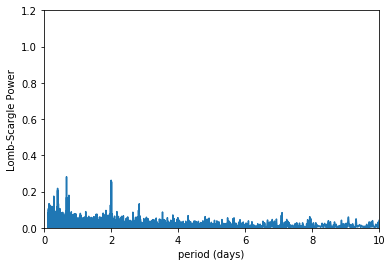

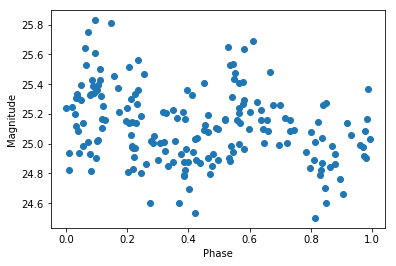

('actualperiod', 0.6666666666666666, 'measured period', 1.9999821367657937) 150
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


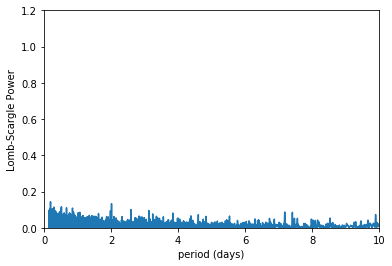

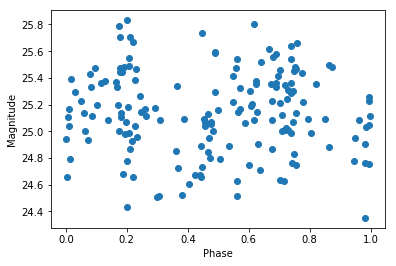

('actualperiod', 0.6666666666666666, 'measured period', 0.052006996959928602) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


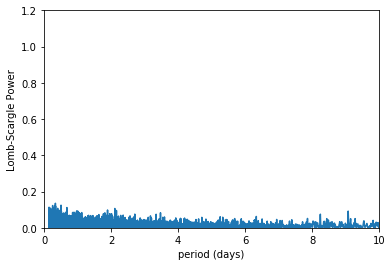

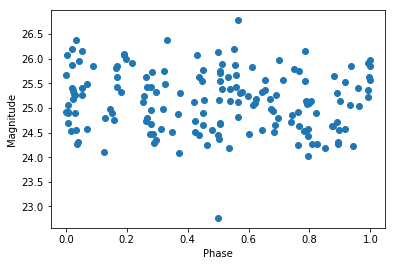

('actualperiod', 0.6666666666666666, 'measured period', 0.01427864661261349) 150


In [153]:
# actual frequency = frquency/100
lombScargle([150],[25,25,25,25,25,25,25],Nquist=300) # 40 background corresponing to R band at new moon, could be made more detailed?

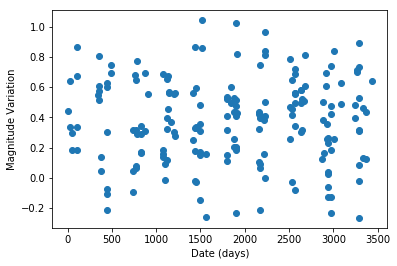

In [137]:
perfex = np.linspace(0, 3500, 3501)
#perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
#plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
#plt.xlim([2200, 2300])
plt.show()

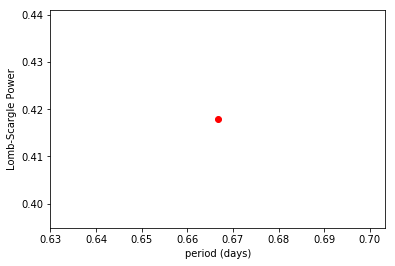

In [138]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()